# (f) Noise regularization
### Learning images of letters after learning images of digits + noise

In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   
os.environ["CUDA_VISIBLE_DEVICES"]="0"

import torch
from torch import Tensor
import torch.nn as nn
import torch.cuda as cuda
import torch.utils.data as data_utils
from torch.utils.data import DataLoader, Dataset
from torch.nn.parameter import Parameter

try:
    import accimage
except ImportError:
    accimage = None

import random
import copy
import time

import torchvision
from torchvision import datasets
from torchvision import transforms
from torchvision.datasets import ImageFolder

from SpykeTorch import snn
from SpykeTorch import functional as sf
from SpykeTorch import visualization as vis
from SpykeTorch import utils

import struct
import glob
import datetime
import re

from sklearn.datasets import fetch_openml
from sklearn.metrics import confusion_matrix

import pandas as pd
import numpy as np
import seaborn as sn
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

from PIL import Image

## Model

In [2]:
# learning rule

class STDP(nn.Module):
    def __init__(self, conv_layer, learning_rate, eps_std_percent=0.0, \
                 use_stabilizer = True, lower_bound = 0, upper_bound = 1):
        super(STDP, self).__init__()
        self.conv_layer = conv_layer
        if isinstance(learning_rate, list):
            self.learning_rate = learning_rate
        else:
            self.learning_rate = [learning_rate] * conv_layer.out_channels
        for i in range(conv_layer.out_channels):
            self.learning_rate[i] = (Parameter(torch.tensor([self.learning_rate[i][0]])),
                            Parameter(torch.tensor([self.learning_rate[i][1]])))
            self.register_parameter('ltp_' + str(i), self.learning_rate[i][0])
            self.register_parameter('ltd_' + str(i), self.learning_rate[i][1])
            self.learning_rate[i][0].requires_grad_(False)
            self.learning_rate[i][1].requires_grad_(False)
        self.use_stabilizer = use_stabilizer
        self.lower_bound = lower_bound
        self.upper_bound = upper_bound
        self.eps_std_percent = eps_std_percent

    def get_pre_post_ordering(self, input_spikes, output_spikes, winners):

        # accumulating input and output spikes to get latencies
        input_latencies = torch.sum(input_spikes, dim=0)
        output_latencies = torch.sum(output_spikes, dim=0)
        result = []
        for winner in winners:
            # generating repeated output tensor with the same size of the receptive field
            out_tensor = torch.ones(*self.conv_layer.kernel_size, device=output_latencies.device) * output_latencies[winner]
            # slicing input tensor with the same size of the receptive field centered around winner
            # since there is no padding, there is no need to shift it to the center
            in_tensor = input_latencies[:,winner[-2]:winner[-2]+self.conv_layer.kernel_size[-2],winner[-1]:winner[-1]+self.conv_layer.kernel_size[-1]]
            result.append(torch.ge(in_tensor,out_tensor))
        return result

    # the simple STDP rule was supplemented with noise: 
    # eps_std_percent - %% standard deviation of random small addition to learning rate
    # gets prepost pairings, winners, weights, and learning rates (all shoud be tensors)        
    def forward(self, input_spikes, potentials, output_spikes, winners=None, kwta = 1, inhibition_radius = 0):
        if winners is None:
            winners = sf.get_k_winners(potentials, kwta, inhibition_radius, output_spikes)
        
        pairings = self.get_pre_post_ordering(input_spikes, output_spikes, winners)

        lr = torch.zeros_like(self.conv_layer.weight)
        epsilon = torch.torch.zeros_like(lr)
        
        for i in range(len(winners)):
            
            f = winners[i][0]            
            
            lr_0 = self.learning_rate[f][0].item()
            lr_1 = self.learning_rate[f][1].item()
            
            eps_std_0 = np.abs(lr_0) * self.eps_std_percent # standard deviation of random small addition to learning_rate_0
            eps_std_1 = np.abs(lr_1) * self.eps_std_percent # standard deviation of random small addition to learning_rate_1

            if eps_std_0 == 0:
                eps_0 = torch.zeros(1).cuda()
            else:
                eps_0 = torch.normal(mean=torch.zeros(1).cuda(), std=eps_std_0)
                
            if eps_std_1 == 0:
                eps_1 = torch.zeros(1).cuda()
            else:
                eps_1 = torch.normal(mean=torch.zeros(1).cuda(), std=eps_std_1)
            
            learning_rate_0 = torch.nn.Parameter(torch.ones(1).cuda()*lr_0 + eps_0, requires_grad=False)
            learning_rate_1 = torch.nn.Parameter(torch.ones(1).cuda()*lr_1 + eps_1, requires_grad=False)
            
            two_learning_rate = (learning_rate_0, learning_rate_1)
            lr[f] = torch.where(pairings[i], *(two_learning_rate))

        self.conv_layer.weight += \
        lr * ((self.conv_layer.weight-self.lower_bound) * (self.upper_bound-self.conv_layer.weight) \
              if self.use_stabilizer else 1) 
        self.conv_layer.weight.clamp_(self.lower_bound, self.upper_bound)

    def update_learning_rate(self, feature, ap, an):
        self.learning_rate[feature][0][0] = ap
        self.learning_rate[feature][1][0] = an

    def update_all_learning_rate(self, ap, an):
        for feature in range(self.conv_layer.out_channels):
            self.learning_rate[feature][0][0] = ap
            self.learning_rate[feature][1][0] = an

In [3]:
# model

class MozafariMNIST2018(nn.Module):
    
    def __init__(self, eps_std_percent=0.0):
        
        super(MozafariMNIST2018, self).__init__()

        self.conv1 = snn.Convolution(6, 30, 5, 0.8, 0.05)
        self.conv1_t = 15
        self.k1 = 5
        self.r1 = 3

        self.conv2 = snn.Convolution(30, 250, 3, 0.8, 0.05)
        self.conv2_t = 10
        self.k2 = 8
        self.r2 = 1

        self.conv3 = snn.Convolution(250, 200, 5, 0.8, 0.05)
        
        self.eps_std_percent = eps_std_percent

        self.stdp1 = STDP(self.conv1, (0.004, -0.003))
        self.stdp2 = STDP(self.conv2, (0.004, -0.003))
        self.stdp3 = STDP(self.conv3, (0.004, -0.003), self.eps_std_percent, False, 0.2, 0.8)
        self.anti_stdp3 = STDP(self.conv3, (-0.004, 0.0005), self.eps_std_percent, False, 0.2, 0.8)
        self.max_ap = Parameter(torch.Tensor([0.15]))

        self.decision_map = []
        for i in range(10):
            self.decision_map.extend([i]*20)

        self.ctx = {"input_spikes":None, "potentials":None, "output_spikes":None, "winners":None}
        self.spk_cnt1 = 0
        self.spk_cnt2 = 0

    def forward(self, input, max_layer):
        
        input = sf.pad(input.float(), (2,2,2,2), 0)
        
        if self.training:
            pot = self.conv1(input)
            spk, pot = sf.fire(pot, self.conv1_t, True)
            if max_layer == 1:
                self.spk_cnt1 += 1
                if self.spk_cnt1 >= 500:
                    self.spk_cnt1 = 0
                    ap = torch.tensor(self.stdp1.learning_rate[0][0].item(), device=self.stdp1.learning_rate[0][0].device) * 2
                    ap = torch.min(ap, self.max_ap)
                    an = ap * -0.75
                    self.stdp1.update_all_learning_rate(ap.item(), an.item())
                pot = sf.pointwise_inhibition(pot)
                spk = pot.sign()
                winners = sf.get_k_winners(pot, self.k1, self.r1, spk)
                self.ctx["input_spikes"] = input
                self.ctx["potentials"] = pot
                self.ctx["output_spikes"] = spk
                self.ctx["winners"] = winners
                return spk, pot
            
            spk_in = sf.pad(sf.pooling(spk, 2, 2), (1,1,1,1))
            pot = self.conv2(spk_in)
            spk, pot = sf.fire(pot, self.conv2_t, True)
            if max_layer == 2:
                self.spk_cnt2 += 1
                if self.spk_cnt2 >= 500:
                    self.spk_cnt2 = 0
                    ap = torch.tensor(self.stdp2.learning_rate[0][0].item(), device=self.stdp2.learning_rate[0][0].device) * 2
                    ap = torch.min(ap, self.max_ap)
                    an = ap * -0.75
                    self.stdp2.update_all_learning_rate(ap.item(), an.item())
                pot = sf.pointwise_inhibition(pot)
                spk = pot.sign()
                winners = sf.get_k_winners(pot, self.k2, self.r2, spk)
                self.ctx["input_spikes"] = spk_in
                self.ctx["potentials"] = pot
                self.ctx["output_spikes"] = spk
                self.ctx["winners"] = winners
                return spk, pot
            
            spk_in = sf.pad(sf.pooling(spk, 3, 3), (2,2,2,2))
            pot = self.conv3(spk_in)
            spk = sf.fire(pot)
            winners = sf.get_k_winners(pot, 1, 0, spk)
            self.ctx["input_spikes"] = spk_in
            self.ctx["potentials"] = pot
            self.ctx["output_spikes"] = spk
            self.ctx["winners"] = winners
            output = -1
            if len(winners) != 0:
                output = self.decision_map[winners[0][0]]
            return output
        
        else:
            pot = self.conv1(input)
            spk, pot = sf.fire(pot, self.conv1_t, True)
            if max_layer == 1:
                return spk, pot
            
            pot = self.conv2(sf.pad(sf.pooling(spk, 2, 2), (1,1,1,1)))
            spk, pot = sf.fire(pot, self.conv2_t, True)
            if max_layer == 2:
                return spk, pot
            pot = self.conv3(sf.pad(sf.pooling(spk, 3, 3), (2,2,2,2)))
            spk = sf.fire(pot)
            winners = sf.get_k_winners(pot, 1, 0, spk)
            output = -1
            if len(winners) != 0:
                output = self.decision_map[winners[0][0]]
            return output

    def stdp(self, layer_idx):
        if layer_idx == 1:
            self.stdp1(self.ctx["input_spikes"], self.ctx["potentials"], self.ctx["output_spikes"], self.ctx["winners"])
        if layer_idx == 2:
            self.stdp2(self.ctx["input_spikes"], self.ctx["potentials"], self.ctx["output_spikes"], self.ctx["winners"])

    def update_learning_rates(self, stdp_ap, stdp_an, anti_stdp_ap, anti_stdp_an):
        self.stdp3.update_all_learning_rate(stdp_ap, stdp_an)
        self.anti_stdp3.update_all_learning_rate(anti_stdp_an, anti_stdp_ap)

    def reward(self):
        self.stdp3(self.ctx["input_spikes"], self.ctx["potentials"], self.ctx["output_spikes"], self.ctx["winners"])

    def punish(self):
        self.anti_stdp3(self.ctx["input_spikes"], self.ctx["potentials"], self.ctx["output_spikes"], self.ctx["winners"])


In [4]:
# train and test

def train_unsupervise(network, data, layer_idx):
    network.train()
    
    for i in range(len(data)):
        data_in = data[i]
        if use_cuda:
            data_in = data_in.cuda()
        network(data_in, layer_idx)
        network.stdp(layer_idx)

def train_rl(network, data, target):
    network.train()
    perf = np.array([0,0,0]) # correct, wrong, silence
    for i in range(len(data)):
        data_in = data[i]
        target_in = target[i]
        if use_cuda:
            data_in = data_in.cuda()
            target_in = target_in.cuda()
        d = network(data_in, 3)
        if d != -1:
            if d == target_in:
                perf[0]+=1
                network.reward()
            else:
                perf[1]+=1
                network.punish()
        else:
            perf[2]+=1
    return perf/len(data)

def test(network, data, target):
    network.eval()
    perf = np.array([0,0,0]) # correct, wrong, silence
    for i in range(len(data)):
        data_in = data[i]
        target_in = target[i]
        if use_cuda:
            data_in = data_in.cuda()
            target_in = target_in.cuda()
        d = network(data_in, 3)
        if d != -1:
            if d == target_in:
                perf[0]+=1
            else:
                perf[1]+=1
        else:
            perf[2]+=1
    return perf/len(data)

In [5]:
def curve_graph(parametr_set):

    plt.subplots(figsize=(15, 5))

    plt.plot(parametr_set['epoch'], parametr_set['train']*100, color='cyan', label='train')
    plt.plot(parametr_set['epoch'], parametr_set['test']*100, color='blue', marker = 'o', label='test')
    plt.plot(parametr_set['epoch'], parametr_set['test_previous']*100, linestyle = ':', color='red', label='test of previous images')
    plt.xlabel('epochs', loc='right', fontsize=17)
    plt.ylabel('accuracy, %',  loc='top', fontsize=17)
    plt.grid()
    plt.legend()
    plt.show()

In [6]:
# training of the 3rd layer

def third_layer(file_name_net, file_name_csv, adaptive_int, previous_epochs, epochs, 
                train_loader, test_loader, test_previous_loader,
                model, apr, anr, app, anp, parametr_set, steps=None, percent=20, it_continues=False):  
    
    '''
    file_name_net - name of file for saving state_dict of model
    file_name_csv - name of file for saving parameters of model in each epoch
    adaptive_int - learning rate parameter
    previous_epochs - if before model had training in current period
    it_continues - is it continue of 3-rd layer training or not (False or True)
    percent - percent of moving weights (calculated from the number of high range weights)
    '''

    adaptive_min=0 

    if not it_continues:

        previous_epochs = 0
        counter = 0

        apr_adapt = ((1.0 - 1.0 / 10) * adaptive_int + adaptive_min) * apr
        anr_adapt = ((1.0 - 1.0 / 10) * adaptive_int + adaptive_min) * anr
        app_adapt = ((1.0 / 10) * adaptive_int + adaptive_min) * app
        anp_adapt = ((1.0 / 10) * adaptive_int + adaptive_min) * anp
        
        best_train = np.array([0.0,0.0,0.0,0.0]) # correct, wrong, silence, epoch
        best_test = np.array([0.0,0.0,0.0,0.0]) # correct, wrong, silence, epoch
        best_test_previous = np.array([0.0,0.0,0.0,0.0]) # correct, wrong, silence, epoch

    else:
      
        if len(parametr_set.loc[parametr_set['test'] == parametr_set['test'].max(), 'epoch']) == 1:
            optim_index = int(parametr_set.loc[parametr_set['test'] == parametr_set['test'].max(), 'epoch'].item())
        else:
            optim_index = int(parametr_set.loc[parametr_set['test'] == parametr_set['test'].max(), 'epoch'].tolist()[-1])

        if len(parametr_set.loc[parametr_set['train'] == parametr_set['train'].max(), 'epoch']) == 1:
            best_train_index = int(parametr_set.loc[parametr_set['train'] == parametr_set['train'].max(), 'epoch'].item())
        else:
            best_train_index = int(parametr_set.loc[parametr_set['train'] == parametr_set['train'].max(), 'epoch'].tolist()[-1])

        if len(parametr_set.loc[parametr_set['test_previous'] == parametr_set['test_previous'].max(), 'epoch']) == 1:
            best_test_previous_index = int(parametr_set.loc[parametr_set['test_previous'] == parametr_set['test_previous'].max(), 'epoch'].item())
        else:
            best_test_previous_index = int(parametr_set.loc[parametr_set['test_previous'] == parametr_set['test_previous'].max(), 'epoch'].tolist()[-1])
        
        max_index = int(parametr_set.index.max())
        counter = (max_index + 1)

        param_best_train = parametr_set['train'].iloc[best_train_index]
        param_best_test = parametr_set['test'].iloc[optim_index]
        param_best_test_previous = parametr_set['test_previous'].iloc[best_test_previous_index]

        apr_adapt = parametr_set['apr_adapt'].iloc[optim_index]
        anr_adapt = parametr_set['anr_adapt'].iloc[optim_index]
        app_adapt = parametr_set['app_adapt'].iloc[optim_index]
        anp_adapt = parametr_set['anp_adapt'].iloc[optim_index]
        
        for i in range(len(mozafari.stdp3.learning_rate)):
            mozafari.stdp3.learning_rate[i][0].fill_(parametr_set['stdp3.learning_rate[0]'].iloc[optim_index])
            mozafari.stdp3.learning_rate[i][1].fill_(parametr_set['stdp3.learning_rate[1]'].iloc[optim_index])
            mozafari.anti_stdp3.learning_rate[0][0].fill_(parametr_set['anti_stdp3.learning_rate[0]'].iloc[optim_index])
            mozafari.anti_stdp3.learning_rate[0][0].fill_(parametr_set['anti_stdp3.learning_rate[1]'].iloc[optim_index])

        best_train = np.array([param_best_train,1-param_best_train,0.0,best_train_index]) # correct, wrong, silence, epoch
        best_test = np.array([param_best_test,1-param_best_test,0.0,optim_index]) # correct, wrong, silence, epoch
        best_test_previous = np.array([param_best_test_previous,1-param_best_test_previous,0.0,best_test_previous_index]) # correct, wrong, silence, epoch
    
    # list of 3-rd layer weights

    dim_0, dim_1, dim_2, dim_3 = tuple(mozafari.conv3.weight.size())
    total_size = dim_0 * dim_1 * dim_2 * dim_3
  
    # indexes of weights
    indexes_i = []    
    indexes_j = []        
    indexes_k = []        
    indexes_m = []    
    
    # values of weights
    item_values = []  
    
    for i in range(dim_0):
        for j in range(dim_1):
            for k in range(dim_2):
                for m in range(dim_3):
                    indexes_i.append(i)
                    indexes_j.append(j)
                    indexes_k.append(k)
                    indexes_m.append(m)
                    item_values.append(mozafari.conv3.weight[i][j][k][m].item())

    indexes_dim_0 = pd.Series(indexes_i, name='dim_0') 
    indexes_dim_1 = pd.Series(indexes_j, name='dim_1')
    indexes_dim_2 = pd.Series(indexes_k, name='dim_2')
    indexes_dim_3 = pd.Series(indexes_m, name='dim_3')
    item_values = pd.Series(item_values, name='value_0')
            
    conv3_data = pd.concat([item_values, indexes_dim_0, indexes_dim_1, indexes_dim_2, indexes_dim_3], axis=1)
    
    high_percent = 85 #percent of high range weights
    percentile_value = np.percentile(item_values, high_percent)
    
    conv3_data['low_range_0'] = 0
    conv3_data.loc[conv3_data['value_0'] < percentile_value,'low_range_0'] = 1
    
    try:
        high_range_counter = conv3_data['low_range_0'].value_counts()[0] 
    except:
        high_range_counter = 1
 
    moving_quantity = int((percent/100)*high_range_counter) #quantity of moving items in each epoch
    
    if steps is None:
        steps = int(total_size*high_percent/(100*moving_quantity))   #steps of weights moving 
    print(f'Weight moving will be during {steps} epochs')
    
    for epoch in range(epochs):
        
        seconds_epoch_0 = time.time() 
        
        print('-'*50)
        print("Epoch #: ", epoch + previous_epochs)
        
        perf_train = np.array([0.0,0.0,0.0]) 
        
        for data,targets in train_loader:
                
            if epoch < steps: 
                
                print(f'Values of high range weights in epoch#{epoch} [{percentile_value :.3f}:0.800] (top {100-high_percent}%)')
                low_range_indexes = list(conv3_data.index[conv3_data['low_range_'+str(epoch)] == 1])
                moving_items = random.sample(low_range_indexes, np.minimum(moving_quantity, len(low_range_indexes)))
                moving_indexes = conv3_data.loc[conv3_data.index.isin(moving_items)]

                print(f'Quantity of moving points in epoch#{epoch + previous_epochs} = {len(moving_indexes.index)} items' 
                      f' ({len(moving_indexes.index)/(total_size-high_range_counter)*100 :.1f}% of moving points)')

                for q in range(len(moving_indexes.index)):
                    mozafari.conv3.weight \
                    [moving_indexes['dim_0'].iloc[q]][moving_indexes['dim_1'].iloc[q]][moving_indexes['dim_2'].iloc[q]][moving_indexes['dim_3'].iloc[q]]. \
                    fill_(np.random.normal(loc=0.8, scale=0.05))  
              
            perf_train_batch = train_rl(model, data, targets)
    
            if epoch < steps:  
            
                # new values of weights (after learning)
                item_values = []       
                for i in range(dim_0):
                    for j in range(dim_1):
                        for k in range(dim_2):
                            for m in range(dim_3):
                                item_values.append(mozafari.conv3.weight[i][j][k][m].item())
            
                item_values = pd.Series(item_values, name='value_'+str(epoch+1))
                percentile_value = np.percentile(item_values, high_percent) #new cutting off high range weights
                conv3_data = pd.concat([conv3_data, item_values], axis=1)
                
                conv3_data['low_range_'+str(epoch+1)] = 0
                conv3_data.loc[conv3_data['value_'+str(epoch+1)] < percentile_value,'low_range_'+str(epoch+1)] = 1
       
            #update adaptive learning rates
            apr_adapt = apr * (perf_train_batch[1] * adaptive_int + adaptive_min)
            anr_adapt = anr * (perf_train_batch[1] * adaptive_int + adaptive_min)
            app_adapt = app * (perf_train_batch[0] * adaptive_int + adaptive_min)
            anp_adapt = anp * (perf_train_batch[0] * adaptive_int + adaptive_min)
            parametr_set.loc[counter, 'epoch'] = epoch + previous_epochs
            parametr_set.loc[counter, 'apr_adapt'] = apr_adapt
            parametr_set.loc[counter, 'anr_adapt'] = anr_adapt
            parametr_set.loc[counter, 'app_adapt'] = app_adapt
            parametr_set.loc[counter, 'anp_adapt'] = anp_adapt
            parametr_set.loc[counter, 'stdp3.learning_rate[0]'] = mozafari.stdp3.learning_rate[0][0].item()
            parametr_set.loc[counter, 'stdp3.learning_rate[1]'] = mozafari.stdp3.learning_rate[0][1].item()
            parametr_set.loc[counter, 'anti_stdp3.learning_rate[0]'] = mozafari.anti_stdp3.learning_rate[0][0].item()
            parametr_set.loc[counter, 'anti_stdp3.learning_rate[1]'] = mozafari.anti_stdp3.learning_rate[0][1].item()
            parametr_set.loc[counter, 'train'] = perf_train_batch[0]

            model.update_learning_rates(apr_adapt, anr_adapt, app_adapt, anp_adapt)
            perf_train += perf_train_batch
            
        perf_train /= len(train_loader)

        if best_train[0] <= perf_train[0]:
            best_train = np.append(perf_train, epoch + previous_epochs)
        print(f"Current Train: {perf_train[0]*100 :.2f}%")
        #print("   Best Train:", best_train)

        for data,targets in test_loader:
            perf_test = test(model, data, targets)
            parametr_set.loc[counter, 'test'] = perf_test[0]
            if best_test[0] <= perf_test[0]:
                best_test = np.append(perf_test, epoch + previous_epochs)
                torch.save(model.state_dict(), file_name_net)
            print(f"Current Test: {perf_test[0]*100 :.2f}%")
            #print("    Best Test:", best_test)

        if isinstance(test_previous_loader, DataLoader):
            for data,targets in test_previous_loader:
                perf_test_previous = test(model, data, targets)
                parametr_set.loc[counter, 'test_previous'] = perf_test_previous[0]
                if best_test_previous[0] <= perf_test_previous[0]:
                    best_test_previous = np.append(perf_test_previous, epoch + previous_epochs)
                print(f"Current Test Previous: {perf_test_previous[0]*100 :.2f}%")
                #print("    Best Test Previous:", best_test_previous)
                
        else:
            parametr_set.loc[counter, 'test_previous'] = 0
            
        counter += 1
                                                 
        seconds_epoch_1 = time.time()  
        print(f'Operational time of epoch #{epoch + previous_epochs}: '
                  f'{int((seconds_epoch_1 - seconds_epoch_0)//60)} min {int((seconds_epoch_1 - seconds_epoch_0)%60)} sec') 
    
    parametr_set.to_csv(file_name_csv)
    
    print('=='*10, 'SUMMARY', '=='*10)
    print(f"        Best Train: {best_train[0]*100 :.2f}% on {best_train[3] :.0f} epoch")
    print(f"         Best Test: {best_test[0]*100 :.2f}% on {best_test[3] :.0f} epoch")
    print(f"Best Test Previous: {best_test_previous[0]*100 :.2f}% on {best_test_previous[3] :.0f} epoch")
    
    return parametr_set, counter, (previous_epochs+epochs), apr, anr, app, anp, conv3_data

In [7]:
# for image transformation (see dataset)

class S1C1Transform:
    
    def __init__(self, filter, PIL_type=False, timesteps = 15):
        self.PIL_type = PIL_type
        self.to_pil_image = transforms.ToPILImage()    
        self.to_tensor = transforms.ToTensor()
        self.filter = filter
        self.temporal_transform = utils.Intensity2Latency(timesteps)
        self.cnt = 0
        
    def __call__(self, image):
        if self.cnt % 20000 == 0:
            print(f'{self.cnt} images')
        if self.PIL_type:
            image = self.to_pil_image(image)
        self.cnt+=1
        image = self.to_tensor(image) * 255
        image.unsqueeze_(0)
        image = self.filter(image)
        image = sf.local_normalization(image, 8)
        temporal_image = self.temporal_transform(image)
        return temporal_image.sign().byte()

In [8]:
# for image transformation (see dataset)

kernels = [ utils.DoGKernel(3,3/9,6/9),
            utils.DoGKernel(3,6/9,3/9),
            utils.DoGKernel(7,7/9,14/9),
            utils.DoGKernel(7,14/9,7/9),
            utils.DoGKernel(13,13/9,26/9),
            utils.DoGKernel(13,26/9,13/9)]

filter = utils.Filter(kernels, padding = 6, thresholds = 50)

s1c1 = S1C1Transform(filter)
s1c1_PIL = S1C1Transform(filter, PIL_type=True)

In [9]:
# for image transformation (see dataset)

class CustomTensorDataset(Dataset):
    """TensorDataset with support of transforms."""
    
    def __init__(self, tensors, transform=None):
        assert all(tensors[0].size(0) == tensor.size(0) for tensor in tensors)
        self.tensors = tensors
        self.transform = transform

    def __getitem__(self, index):
        x = self.tensors[0][index]

        if self.transform:
            x = self.transform(x)

        y = self.tensors[1][index]

        return x, y

    def __len__(self):
        return self.tensors[0].size(0)

## Sets

### Set of 10 capital letters
24000 train images + 4000 test images

In [11]:
# set of 10 capital letters from EMNIST

path = f'./data/EMNIST_own/capital_letters/'

test_letter_labels = torch.load(f'{path}Mozafari_capital_letters_test_labels.pt', map_location=torch.device('cpu'))
test_letters = torch.load(f'{path}Mozafari_capital_letters_test_images.pt', map_location=torch.device('cpu'))

train_letter_labels = torch.load(f'{path}Mozafari_capital_letters_train_labels.pt', map_location=torch.device('cpu'))
train_letters = torch.load(f'{path}Mozafari_capital_letters_train_images.pt', map_location=torch.device('cpu'))

In [12]:
# Element permutation

train_order_l = torch.randperm(train_letter_labels.shape[0])
test_order_l = torch.randperm(test_letter_labels.shape[0])

train_letter_labels = train_letter_labels[train_order_l].view(train_letter_labels.size())
train_letters = train_letters[train_order_l].view(train_letters.size())

test_letter_labels = test_letter_labels[test_order_l].view(test_letter_labels.size())
test_letters = test_letters[test_order_l].view(test_letters.size())

In [13]:
train_letter_set = CustomTensorDataset(tensors=(train_letters, train_letter_labels), transform=s1c1_PIL)
test_letter_set = CustomTensorDataset(tensors=(test_letters, test_letter_labels), transform=s1c1_PIL)

train_letter_loader = DataLoader(train_letter_set, batch_size=len(train_letter_set))
test_letter_loader = DataLoader(test_letter_set, batch_size=len(test_letter_set))

In [14]:
train_letter_labels.size(), test_letter_labels.size()

(torch.Size([24000]), torch.Size([4000]))

### Set of 10 MNIST digits
Reduction 60000 train + 10000 test images to 24000 train + 4000 test images

In [15]:
classes = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

In [16]:
# the set of 10 digit images, the same size as the set of letters (2400 trains + 400 tests per class)
# the MNIST data was pre-divided into 10 classes
path = f'./data/MNIST_0_1_2_3_4_5_6_7_8_9/'

for i in classes: 
    globals()[f'train_digit_{i}_images'] = torch.load(f'{path}train_images_{i}.pt', map_location=torch.device('cpu'))[0:2400]
    globals()[f'train_digit_{i}_labels'] = torch.load(f'{path}train_labels_{i}.pt', map_location=torch.device('cpu'))[0:2400]
    globals()[f'test_digit_{i}_images'] = torch.load(f'{path}test_images_{i}.pt', map_location=torch.device('cpu'))[0:400]
    globals()[f'test_digit_{i}_labels'] = torch.load(f'{path}test_labels_{i}.pt', map_location=torch.device('cpu'))[0:400]

train_MNIST_labels = globals()[f'train_digit_0_labels']
train_MNIST_images = globals()[f'train_digit_0_images']
test_MNIST_labels = globals()[f'test_digit_0_labels']
test_MNIST_images = globals()[f'test_digit_0_images']                                 

for i in range(1, 10):
    train_MNIST_labels = torch.cat((train_MNIST_labels, globals()[f'train_digit_{i}_labels']), 0)
    train_MNIST_images = torch.cat((train_MNIST_images, globals()[f'train_digit_{i}_images']), 0)

    test_MNIST_labels = torch.cat((test_MNIST_labels, globals()[f'test_digit_{i}_labels']), 0)
    test_MNIST_images = torch.cat((test_MNIST_images, globals()[f'test_digit_{i}_images']), 0)

In [17]:
train_MNIST_labels.size(), test_MNIST_labels.size()

(torch.Size([24000]), torch.Size([4000]))

In [18]:
# Element permutation

train_order = torch.randperm(train_MNIST_labels.shape[0])
test_order = torch.randperm(test_MNIST_labels.shape[0])

train_MNIST_labels = train_MNIST_labels[train_order].view(train_MNIST_labels.size())
train_MNIST_images = train_MNIST_images[train_order].view(train_MNIST_images.size())

test_MNIST_labels = test_MNIST_labels[test_order].view(test_MNIST_labels.size())
test_MNIST_images = test_MNIST_images[test_order].view(test_MNIST_images.size())

In [19]:
train_MNIST_set = CustomTensorDataset(tensors=(train_MNIST_images, train_MNIST_labels), transform=s1c1_PIL)
test_MNIST_set = CustomTensorDataset(tensors=(test_MNIST_images, test_MNIST_labels), transform=s1c1_PIL)

train_MNIST_loader = DataLoader(train_MNIST_set, batch_size=len(train_MNIST_set))
test_MNIST_loader = DataLoader(test_MNIST_set, batch_size=len(test_MNIST_set))

### Combined set of digit set + capital letter set

48000 train + 8000 test images

In [20]:
# set of digits + letters 

train_combi_labels = torch.cat((train_MNIST_labels, train_letter_labels), 0)
train_combi_images = torch.cat((train_MNIST_images, train_letters), 0)
test_combi_labels = torch.cat((test_MNIST_labels, test_letter_labels), 0)
test_combi_images = torch.cat((test_MNIST_images, test_letters), 0)

In [21]:
# Element permutation

train_order_c = torch.randperm(train_combi_labels.shape[0])
test_order_c = torch.randperm(test_combi_labels.shape[0])

train_combi_labels = train_combi_labels[train_order_c].view(train_combi_labels.size())
train_combi_images = train_combi_images[train_order_c].view(train_combi_images.size())

test_combi_labels = test_combi_labels[test_order_c].view(test_combi_labels.size())
test_combi_images = test_combi_images[test_order_c].view(test_combi_images.size())

In [22]:
train_combi_set = CustomTensorDataset(tensors=(train_combi_images, train_combi_labels), transform=s1c1_PIL)
test_combi_set = CustomTensorDataset(tensors=(test_combi_images, test_combi_labels), transform=s1c1_PIL)

train_combi_loader = DataLoader(train_combi_set, batch_size=len(train_combi_set))
test_combi_loader = DataLoader(test_combi_set, batch_size=len(test_combi_set))

In [23]:
train_combi_labels.size(), test_combi_labels.size()

(torch.Size([48000]), torch.Size([8000]))

## Model activation
variable _eps_std_percent_ is the standard deviation of the random small addition to the learning rate

In [24]:
# standard deviation of the random small addition to the learning rate
eps_std_percent = 0.5

In [25]:
mozafari = MozafariMNIST2018(eps_std_percent)

use_cuda = True

if torch.cuda.is_available():
    print("CUDA is available")
    device = torch.device("cuda")

if use_cuda:
    mozafari.cuda()   
    
mozafari.eval()

CUDA is available


MozafariMNIST2018(
  (conv1): Convolution()
  (conv2): Convolution()
  (conv3): Convolution()
  (stdp1): STDP(
    (conv_layer): Convolution()
  )
  (stdp2): STDP(
    (conv_layer): Convolution()
  )
  (stdp3): STDP(
    (conv_layer): Convolution()
  )
  (anti_stdp3): STDP(
    (conv_layer): Convolution()
  )
)

## Continuous learning  
Training on set of letters (1st and 2nd layers on letters without noise, 3rd layer on letters with noise)

### Saving all values of parameters before training

In [26]:
learning_rate_from_scratch = {'stdp1': [mozafari.stdp1.learning_rate[0][0].item(), 
                                        mozafari.stdp1.learning_rate[0][1].item()],
                              'stdp2': [mozafari.stdp2.learning_rate[0][0].item(), 
                                        mozafari.stdp2.learning_rate[0][1].item()],
                              'stdp3': [mozafari.stdp3.learning_rate[0][0].item(), 
                                        mozafari.stdp3.learning_rate[0][1].item()],
                              'anti_stdp3': [mozafari.anti_stdp3.learning_rate[0][0].item(), 
                                             mozafari.anti_stdp3.learning_rate[0][1].item()]
                             }

### Loading weights of model pretrained on digits with noise
Trained with noise parameter: eps_std_percent - standard deviation for random small additive to learning rate

In [27]:
# file "saved_digits_with_noise_0.net" is the result of the file "(f)_Noise_regularization_(digits+noise).ipynb"
mozafari.load_state_dict(torch.load("saved_digits_with_noise_0.net"))

<All keys matched successfully>

### Training the first layer

In [28]:
print("Training the first layer")

for epoch in range(2):
    print("Epoch", epoch)
    iter = 0
    for data, targets in train_letter_loader:
        print("Iteration", iter)
        train_unsupervise(mozafari, data, 1)
        print("Done!")
        iter+=1

Training the first layer
Epoch 0
0 images
20000 images
Iteration 0
Done!
Epoch 1
40000 images
Iteration 0
Done!


### Training the second layer

In [29]:
print("Training the second layer")

for epoch in range(4):
    print("Epoch", epoch)
    iter = 0
    for data,targets in train_letter_loader:
        print("Iteration", iter)
        train_unsupervise(mozafari, data, 2)
        print("Done!")
        iter+=1

Training the second layer
Epoch 0
60000 images
Iteration 0
Done!
Epoch 1
80000 images
Iteration 0
Done!
Epoch 2
100000 images
Iteration 0
Done!
Epoch 3
120000 images
140000 images
Iteration 0
Done!


### Training the third layer
Training with noise parameter: eps_std_percent - standard deviation for random small additive to learning rate

In [30]:
# Moving learning_rates 

for i in range(len(mozafari.stdp3.learning_rate)):
                    mozafari.stdp3.learning_rate[i][0].fill_(learning_rate_from_scratch['stdp3'][0])
                    mozafari.stdp3.learning_rate[i][1].fill_(learning_rate_from_scratch['stdp3'][1])
                    mozafari.anti_stdp3.learning_rate[i][0].fill_(learning_rate_from_scratch['anti_stdp3'][0])
                    mozafari.anti_stdp3.learning_rate[i][1].fill_(learning_rate_from_scratch['anti_stdp3'][1])

In [31]:
# initial adaptive learning rates

apr = mozafari.stdp3.learning_rate[0][0].item()
anr = mozafari.stdp3.learning_rate[0][1].item()
app = mozafari.anti_stdp3.learning_rate[0][1].item()
anp = mozafari.anti_stdp3.learning_rate[0][0].item()
               
parametr_set = pd.DataFrame(columns=['epoch', 'train', 'test', 'test_previous',   
                                 'apr_adapt', 'anr_adapt', 'app_adapt', 'anp_adapt', 
                                 'stdp3.learning_rate[0]', 'stdp3.learning_rate[1]',
                                 'anti_stdp3.learning_rate[0]', 'anti_stdp3.learning_rate[1]'])

* eps_std_percent = 0.5       <== %% standard deviation for random small additive to learning rate
* eps_std_0 = np.abs(lr_0) * self.eps_std_percent     
* eps_std_1 = np.abs(lr_1) * self.eps_std_percent     

In [32]:
first_test = third_layer(file_name_net="saved_letters_after_digits+noise_total_0.net",
                        file_name_csv='parameter_set_letters_after_digits+noise_0.csv',
                        adaptive_int=1.0, previous_epochs=0, epochs=100, 
                        train_loader=train_letter_loader, 
                        test_loader=test_letter_loader, 
                        test_previous_loader=test_MNIST_loader,
                        model=mozafari, apr=apr, anr=anr, app=app, anp=anp, 
                        parametr_set=parametr_set, steps=0, percent=0, it_continues=False)

parametr_set = first_test[0] 
counter = first_test[1] 
previous_epochs = first_test[2]
apr = first_test[3] 
anr = first_test[4] 
app = first_test[5] 
anp = first_test[6]
conv3_data_train = first_test[7]

Weight moving will be during 0 epochs
--------------------------------------------------
Epoch #:  0
160000 images
Current Train: 53.24%
Current Test: 65.80%
Current Test Previous: 56.17%
Operational time of epoch #0: 2 min 33 sec
--------------------------------------------------
Epoch #:  1
180000 images
Current Train: 66.42%
200000 images
Current Test: 65.70%
Current Test Previous: 55.67%
Operational time of epoch #1: 2 min 32 sec
--------------------------------------------------
Epoch #:  2
220000 images
Current Train: 70.09%
Current Test: 69.45%
Current Test Previous: 66.25%
Operational time of epoch #2: 2 min 32 sec
--------------------------------------------------
Epoch #:  3
240000 images
260000 images
Current Train: 72.64%
Current Test: 72.58%
Current Test Previous: 71.17%
Operational time of epoch #3: 2 min 32 sec
--------------------------------------------------
Epoch #:  4
280000 images
Current Train: 74.82%
Current Test: 74.67%
300000 images
Current Test Previous: 70.10

1440000 images
Current Train: 87.23%
Current Test: 85.97%
Current Test Previous: 72.28%
Operational time of epoch #40: 2 min 34 sec
--------------------------------------------------
Epoch #:  41
1460000 images
Current Train: 87.24%
1480000 images
Current Test: 85.85%
Current Test Previous: 69.30%
Operational time of epoch #41: 2 min 32 sec
--------------------------------------------------
Epoch #:  42
1500000 images
Current Train: 87.42%
Current Test: 86.42%
Current Test Previous: 71.50%
Operational time of epoch #42: 2 min 34 sec
--------------------------------------------------
Epoch #:  43
1520000 images
1540000 images
Current Train: 87.40%
Current Test: 86.08%
Current Test Previous: 70.28%
Operational time of epoch #43: 2 min 33 sec
--------------------------------------------------
Epoch #:  44
1560000 images
Current Train: 87.60%
Current Test: 85.88%
1580000 images
Current Test Previous: 71.47%
Operational time of epoch #44: 2 min 32 sec
---------------------------------------

2720000 images
Current Train: 89.87%
Current Test: 87.95%
Current Test Previous: 69.38%
Operational time of epoch #80: 2 min 37 sec
--------------------------------------------------
Epoch #:  81
2740000 images
Current Train: 89.99%
2760000 images
Current Test: 87.78%
Current Test Previous: 67.65%
Operational time of epoch #81: 2 min 36 sec
--------------------------------------------------
Epoch #:  82
2780000 images
Current Train: 89.97%
Current Test: 87.92%
Current Test Previous: 69.25%
Operational time of epoch #82: 2 min 36 sec
--------------------------------------------------
Epoch #:  83
2800000 images
2820000 images
Current Train: 90.22%
Current Test: 87.83%
Current Test Previous: 67.85%
Operational time of epoch #83: 2 min 36 sec
--------------------------------------------------
Epoch #:  84
2840000 images
Current Train: 89.91%
Current Test: 87.85%
2860000 images
Current Test Previous: 70.75%
Operational time of epoch #84: 2 min 35 sec
---------------------------------------

## Results chart

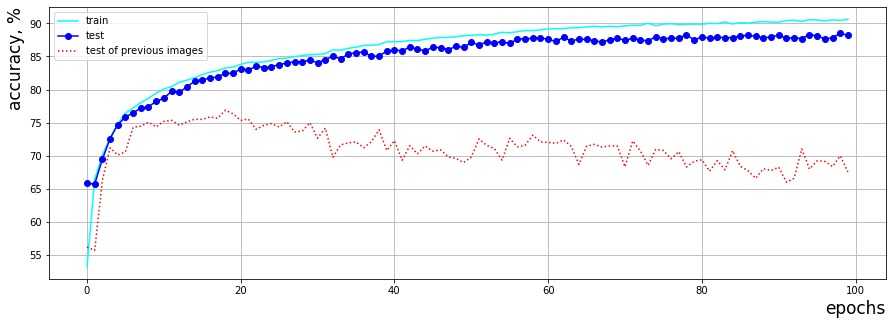

In [33]:
curve_graph(parametr_set)